In [1]:
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

C:\Users\Connor\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.cross_validation import StratifiedKFold
import IPython.display as ipd
import os
from scipy.io import wavfile as wav
from __future__ import division
from tqdm import tqdm
import librosa
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline

C:\Users\Connor\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from IPython.display import Image


# Capstone: Building a Sound Recognition Engine

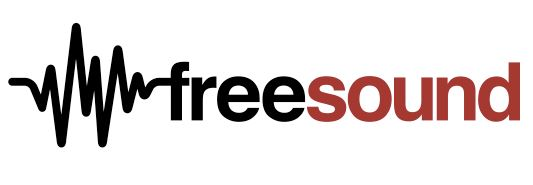

In [55]:
Image('freesound.jpg')

### Goals and Procedure

My main goal for this capstone project is to build an audio recognition engine using Keras. In the modern age sound and voice recognition technologies have become extremely popular with such products as Amazon's Alexa and Google Home, and I thought it would be exciting to try and build something similar. 

Our data consists of 28 different categories of sound ranging from things such as guitars to steam whistles. By utilizing the neural networks we create through Keras I hope to be able to take a given sound and be able to properly categorize it into one of these 28 categories. 

Our data is taken from https://data.vision.ee.ethz.ch/cvl/ae_dataset/ and is authored by 
Naoya Takahashi, Michael Gygli, Beat Pfister and Luc Van Gool,
"Deep Convolutional Neural Networks and Data Augmentation for Acoustic Event Recognition",
 Proc. Interspeech 2016, San Fransisco

### Cleaning the Data

In [4]:
train= 'AudioEventDataset/train'
test= 'AudioEventDataset/test'
#Locating the Path for our training and test sets

In [5]:
os.path.abspath('AudioEventDataset/train')

'C:\\Windows\\system32\\AudioEventDataset\\train'

In [6]:
data_path='AudioEventDataset/train'
#dir_list= os.listdir(data_path)  #list of folders  
#for i in dir_list:
    #if not i.startswith('.'):
        #file_list = os.listdir(data_path+ '/' + i) 
        #for j in file_list: 
            #fname= data_path+'/' + i + '/' + j
            #ipd.Audio(fname)

In [7]:
#Extracting the categories of our data.
data_path='AudioEventDataset/train'
dir_list= os.listdir(data_path)  #list of folders  
X=[]
y=[]
for i in dir_list:
    if not i.startswith('.'):
        file_list = os.listdir(data_path+ '/' + i) 
        
        print (i)
        for j in file_list: 
            fname= data_path+'/' + i + '/' + j
           # print (fname)
            rate, data = wav.read(fname)
            X.append(data)
            y.append(i)
        

acoustic_guitar
airplane
applause
bird
car
cat
child
church_bell
crowd
dog_barking
engine
fireworks
footstep
glass_breaking
hammer
helicopter
knock
laughter
mouse_click
ocean_surf
rustle
scream
speech_fs
squeak
tone
violin
water_tap
whistle


### Visualizing the Data

In [8]:
#looking at our first wav file
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  16000
Total samples (frames) =  174400
Duration =  10.9


In [9]:
# Using scipy to further investigate
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  16000
Total samples (frames) =  (174400,)
[-1660 -6080 -8146 ...    -5    83   111]


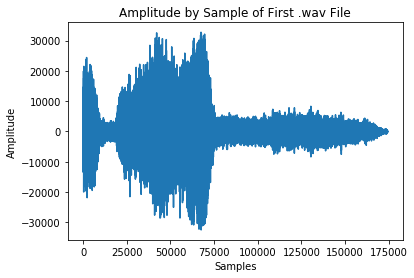

In [10]:
#plotting our first file 
plt.plot(data, '-', )
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Amplitude by Sample of First .wav File')
plt.show()

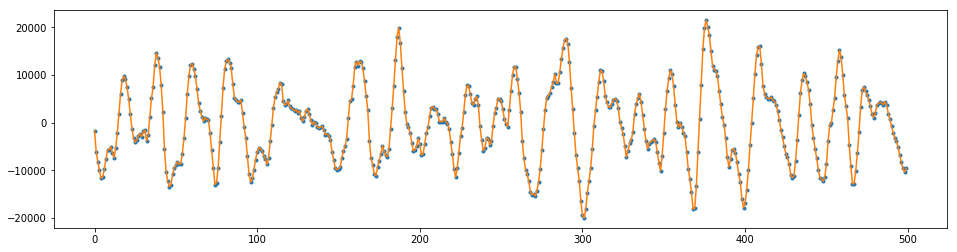

In [11]:
#Plotting the first 500 frames of our first audio file
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.');
plt.plot(data[:500], '-')
plt.show()

The samples and amplitudes of any given file provide a nice visual representation of how many datapoints can be found in any given 10 second sound.

## Preprocessing

In [12]:
import librosa

In [13]:
def get_labels(path=data_path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [14]:
def wav2mfcc(file_path, max_len=100):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::1]
    mfcc = librosa.feature.mfcc(wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc


Feature Extraction, standardizing mfcc to 20.

In [15]:
## load training data 
path=train
max_len=100
labels, label_indices, _ = get_labels(path)


for i, label in enumerate(labels):
    if i==0:  
        mfcc_vectors = []
        final_labels=[] 
        wavfiles = [path + '/'+ label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
            final_labels.append(i)
        X_train=np.array(mfcc_vectors)
        y_train=final_labels 

    else:
        mfcc_vectors = []
        final_labels=[] 
        wavfiles = [path + '/'+ label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
            final_labels.append(i)
            
        X_train=np.vstack((X_train, np.array(mfcc_vectors)))
        y_train= np.append(y_train, final_labels) 

Saving vectors of label - 'whistle': 100%|█████| 63/63 [00:01<00:00, 39.57it/s]


In [16]:
## load test data 
path=test
max_len=100 # we want to pad the frames to 100 if a file has less than 100 frames, if not take the first 100 frames
#grid searched on the 'optimal' max_len 
labels, label_indices, _ = get_labels(path)



for i, label in enumerate(labels):
    if i==0: 
        mfcc_vectors = []
        final_labels=[] 
        wavfiles = [path + '/'+ label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
            final_labels.append(i)
        X_test=np.array(mfcc_vectors)
        y_test=final_labels

    else:
        mfcc_vectors = []
        final_labels=[] 
        wavfiles = [path + '/'+ label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
            final_labels.append(i)
        X_test=np.vstack((X_test, np.array(mfcc_vectors)))
        y_test= np.append(y_test , final_labels)

Saving vectors of label - 'whistle': 100%|█████| 15/15 [00:00<00:00, 51.79it/s]


In [17]:
X_train.shape, y_train.shape #X_train is 3d with 3831 files each is a matrix of  20 x 100 

((3831, 20, 100), (3831,))

In [18]:
X_test.shape, y_test.shape # X_test is 3d with 1212 files each is 20 x 100 

((1212, 20, 100), (1212,))

## Building and Fitting Our Model

In [19]:
# First try keras dense model (simplest of all keras models with short run time!)

# Convert labels to one hot vectors
y_train_dense = to_categorical(y_train, num_classes=28)
y_test_dense = to_categorical(y_test, num_classes=28)

#Reshape X_train, X_test  

X_train_dense=X_train.reshape(3831, 2000)  # now each audio file is a 1d array of 2000  
X_test_dense=X_test.reshape(1212, 2000) 


# Build the model 

#The first layer has 512 neurons and expects 20000 input variables. 
#The second hidden layer has 512 neurons 
#And finally, the output layer has 28 neuron to predict the 28 classes
#Drop outs are added to insert some noise and ensure NN is as robust as it can be by randomly turning off
#some percentage of neurons  

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=2000)) #input is 2000 = 20 x 100 
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(28, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [20]:
# Train 
model.fit(X_train_dense, y_train_dense, epochs=100, batch_size=64, validation_data=(X_test_dense, y_test_dense))

Train on 3831 samples, validate on 1212 samples
Epoch 1/100
3831/3831 [==============================] - ETA: 17s - loss: 15.4699 - acc: 0.031 - ETA: 7s - loss: 15.4823 - acc: 0.036 - ETA: 5s - loss: 15.2480 - acc: 0.05 - ETA: 4s - loss: 15.2146 - acc: 0.05 - ETA: 3s - loss: 15.3034 - acc: 0.04 - ETA: 3s - loss: 15.3142 - acc: 0.04 - ETA: 2s - loss: 15.2522 - acc: 0.04 - ETA: 2s - loss: 15.1585 - acc: 0.05 - ETA: 2s - loss: 15.0788 - acc: 0.05 - ETA: 2s - loss: 15.0615 - acc: 0.06 - ETA: 2s - loss: 15.0824 - acc: 0.05 - ETA: 1s - loss: 15.0739 - acc: 0.06 - ETA: 1s - loss: 15.0567 - acc: 0.06 - ETA: 1s - loss: 15.0601 - acc: 0.06 - ETA: 1s - loss: 15.0375 - acc: 0.06 - ETA: 1s - loss: 15.0666 - acc: 0.06 - ETA: 1s - loss: 15.0356 - acc: 0.06 - ETA: 1s - loss: 15.0039 - acc: 0.06 - ETA: 1s - loss: 14.9620 - acc: 0.06 - ETA: 0s - loss: 14.9503 - acc: 0.06 - ETA: 0s - loss: 14.9519 - acc: 0.06 - ETA: 0s - loss: 14.9476 - acc: 0.07 - ETA: 0s - loss: 14.9661 - acc: 0.06 - ETA: 0s - loss: 14

3831/3831 [==============================] - ETA: 2s - loss: 13.8515 - acc: 0.14 - ETA: 2s - loss: 14.6070 - acc: 0.09 - ETA: 2s - loss: 14.2041 - acc: 0.11 - ETA: 1s - loss: 14.0674 - acc: 0.12 - ETA: 1s - loss: 13.8515 - acc: 0.14 - ETA: 1s - loss: 13.9660 - acc: 0.13 - ETA: 1s - loss: 13.9144 - acc: 0.13 - ETA: 1s - loss: 14.0314 - acc: 0.12 - ETA: 1s - loss: 14.1191 - acc: 0.12 - ETA: 1s - loss: 14.1033 - acc: 0.12 - ETA: 1s - loss: 14.0530 - acc: 0.12 - ETA: 1s - loss: 14.0554 - acc: 0.12 - ETA: 1s - loss: 14.0595 - acc: 0.12 - ETA: 1s - loss: 14.0127 - acc: 0.13 - ETA: 1s - loss: 14.0007 - acc: 0.13 - ETA: 1s - loss: 14.0339 - acc: 0.12 - ETA: 1s - loss: 14.0627 - acc: 0.12 - ETA: 0s - loss: 14.0499 - acc: 0.12 - ETA: 0s - loss: 14.0674 - acc: 0.12 - ETA: 0s - loss: 14.0829 - acc: 0.12 - ETA: 0s - loss: 14.0715 - acc: 0.12 - ETA: 0s - loss: 14.0792 - acc: 0.12 - ETA: 0s - loss: 14.0686 - acc: 0.12 - ETA: 0s - loss: 14.0925 - acc: 0.12 - ETA: 0s - loss: 14.0769 - acc: 0.12 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 14.6070 - acc: 0.09 - ETA: 2s - loss: 14.8589 - acc: 0.07 - ETA: 2s - loss: 14.9596 - acc: 0.07 - ETA: 2s - loss: 14.5710 - acc: 0.09 - ETA: 1s - loss: 14.6070 - acc: 0.09 - ETA: 1s - loss: 14.5841 - acc: 0.09 - ETA: 1s - loss: 14.5877 - acc: 0.09 - ETA: 1s - loss: 14.6011 - acc: 0.09 - ETA: 1s - loss: 14.5129 - acc: 0.09 - ETA: 1s - loss: 14.5758 - acc: 0.09 - ETA: 1s - loss: 14.5548 - acc: 0.09 - ETA: 1s - loss: 14.5374 - acc: 0.09 - ETA: 1s - loss: 14.5430 - acc: 0.09 - ETA: 1s - loss: 14.5934 - acc: 0.09 - ETA: 1s - loss: 14.5336 - acc: 0.09 - ETA: 1s - loss: 14.5302 - acc: 0.09 - ETA: 1s - loss: 14.5577 - acc: 0.09 - ETA: 0s - loss: 14.5821 - acc: 0.09 - ETA: 0s - loss: 14.5495 - acc: 0.09 - ETA: 0s - loss: 14.5524 - acc: 0.09 - ETA: 0s - loss: 14.5797 - acc: 0.09 - ETA: 0s - loss: 14.5692 - acc: 0.09 - ETA: 0s - loss: 14.5541 - acc: 0.09 - ETA: 0s - loss: 14.5671 - acc: 0.09 - ETA: 0s - loss: 14.5430 - acc: 0.09 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 14.3552 - acc: 0.10 - ETA: 2s - loss: 14.1873 - acc: 0.11 - ETA: 2s - loss: 14.4181 - acc: 0.10 - ETA: 2s - loss: 14.3132 - acc: 0.11 - ETA: 2s - loss: 14.4811 - acc: 0.10 - ETA: 2s - loss: 14.2041 - acc: 0.11 - ETA: 2s - loss: 14.1096 - acc: 0.12 - ETA: 2s - loss: 13.8749 - acc: 0.13 - ETA: 1s - loss: 13.8877 - acc: 0.13 - ETA: 1s - loss: 13.9117 - acc: 0.13 - ETA: 1s - loss: 13.9182 - acc: 0.13 - ETA: 1s - loss: 13.9351 - acc: 0.13 - ETA: 1s - loss: 13.9491 - acc: 0.13 - ETA: 1s - loss: 13.9222 - acc: 0.13 - ETA: 1s - loss: 13.8812 - acc: 0.13 - ETA: 1s - loss: 13.9128 - acc: 0.13 - ETA: 1s - loss: 13.9326 - acc: 0.13 - ETA: 1s - loss: 13.9944 - acc: 0.13 - ETA: 1s - loss: 14.0145 - acc: 0.13 - ETA: 0s - loss: 14.0390 - acc: 0.12 - ETA: 0s - loss: 14.0423 - acc: 0.12 - ETA: 0s - loss: 14.0632 - acc: 0.12 - ETA: 0s - loss: 14.0707 - acc: 0.12 - ETA: 0s - loss: 14.0721 - acc: 0.12 - ETA: 0s - loss: 14.0787 - acc: 0.12 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 13.8515 - acc: 0.14 - ETA: 2s - loss: 14.4391 - acc: 0.10 - ETA: 2s - loss: 14.4388 - acc: 0.10 - ETA: 2s - loss: 14.3070 - acc: 0.11 - ETA: 1s - loss: 14.3447 - acc: 0.10 - ETA: 1s - loss: 14.4611 - acc: 0.10 - ETA: 1s - loss: 14.4448 - acc: 0.10 - ETA: 1s - loss: 14.5168 - acc: 0.09 - ETA: 1s - loss: 14.4575 - acc: 0.10 - ETA: 1s - loss: 14.4599 - acc: 0.10 - ETA: 1s - loss: 14.4620 - acc: 0.10 - ETA: 1s - loss: 14.5293 - acc: 0.09 - ETA: 1s - loss: 14.5859 - acc: 0.09 - ETA: 1s - loss: 14.6248 - acc: 0.09 - ETA: 1s - loss: 14.7104 - acc: 0.08 - ETA: 1s - loss: 14.7200 - acc: 0.08 - ETA: 1s - loss: 14.7055 - acc: 0.08 - ETA: 0s - loss: 14.7037 - acc: 0.08 - ETA: 0s - loss: 14.6985 - acc: 0.08 - ETA: 0s - loss: 14.6938 - acc: 0.08 - ETA: 0s - loss: 14.6527 - acc: 0.09 - ETA: 0s - loss: 14.6096 - acc: 0.09 - ETA: 0s - loss: 14.6095 - acc: 0.09 - ETA: 0s - loss: 14.5986 - acc: 0.09 - ETA: 0s - loss: 14.5784 - acc: 0.09 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 13.5996 - acc: 0.15 - ETA: 2s - loss: 13.6836 - acc: 0.15 - ETA: 2s - loss: 13.7508 - acc: 0.14 - ETA: 2s - loss: 13.9234 - acc: 0.13 - ETA: 2s - loss: 13.8235 - acc: 0.14 - ETA: 2s - loss: 13.9202 - acc: 0.13 - ETA: 2s - loss: 13.9832 - acc: 0.13 - ETA: 1s - loss: 13.9656 - acc: 0.13 - ETA: 1s - loss: 14.0263 - acc: 0.12 - ETA: 1s - loss: 14.0742 - acc: 0.12 - ETA: 1s - loss: 14.0756 - acc: 0.12 - ETA: 1s - loss: 14.1010 - acc: 0.12 - ETA: 1s - loss: 14.1187 - acc: 0.12 - ETA: 1s - loss: 14.0982 - acc: 0.12 - ETA: 1s - loss: 14.1370 - acc: 0.12 - ETA: 1s - loss: 14.1768 - acc: 0.11 - ETA: 1s - loss: 14.1407 - acc: 0.12 - ETA: 1s - loss: 14.1607 - acc: 0.12 - ETA: 1s - loss: 14.1575 - acc: 0.12 - ETA: 0s - loss: 14.1697 - acc: 0.12 - ETA: 0s - loss: 14.1663 - acc: 0.12 - ETA: 0s - loss: 14.1716 - acc: 0.12 - ETA: 0s - loss: 14.1860 - acc: 0.11 - ETA: 0s - loss: 14.1823 - acc: 0.11 - ETA: 0s - loss: 14.1736 - acc: 0.12 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 14.1033 - acc: 0.12 - ETA: 2s - loss: 13.7675 - acc: 0.14 - ETA: 2s - loss: 13.7004 - acc: 0.15 - ETA: 2s - loss: 13.7795 - acc: 0.14 - ETA: 2s - loss: 13.9075 - acc: 0.13 - ETA: 2s - loss: 13.9660 - acc: 0.13 - ETA: 1s - loss: 14.1227 - acc: 0.12 - ETA: 1s - loss: 14.1033 - acc: 0.12 - ETA: 1s - loss: 13.9996 - acc: 0.13 - ETA: 1s - loss: 14.0152 - acc: 0.12 - ETA: 1s - loss: 14.0476 - acc: 0.12 - ETA: 1s - loss: 13.9867 - acc: 0.13 - ETA: 1s - loss: 13.9860 - acc: 0.13 - ETA: 1s - loss: 14.0693 - acc: 0.12 - ETA: 1s - loss: 14.0803 - acc: 0.12 - ETA: 1s - loss: 14.1062 - acc: 0.12 - ETA: 1s - loss: 14.1365 - acc: 0.12 - ETA: 1s - loss: 14.1131 - acc: 0.12 - ETA: 0s - loss: 14.1261 - acc: 0.12 - ETA: 0s - loss: 14.1250 - acc: 0.12 - ETA: 0s - loss: 14.0748 - acc: 0.12 - ETA: 0s - loss: 14.0703 - acc: 0.12 - ETA: 0s - loss: 14.0424 - acc: 0.12 - ETA: 0s - loss: 14.0122 - acc: 0.13 - ETA: 0s - loss: 14.0055 - acc: 0.13 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 14.3552 - acc: 0.10 - ETA: 2s - loss: 14.1033 - acc: 0.12 - ETA: 2s - loss: 13.8515 - acc: 0.14 - ETA: 2s - loss: 13.7795 - acc: 0.14 - ETA: 2s - loss: 13.7955 - acc: 0.14 - ETA: 1s - loss: 13.7370 - acc: 0.14 - ETA: 1s - loss: 13.7353 - acc: 0.14 - ETA: 1s - loss: 13.7843 - acc: 0.14 - ETA: 1s - loss: 13.7478 - acc: 0.14 - ETA: 1s - loss: 13.7985 - acc: 0.14 - ETA: 1s - loss: 13.8395 - acc: 0.14 - ETA: 1s - loss: 13.8515 - acc: 0.14 - ETA: 1s - loss: 13.8716 - acc: 0.13 - ETA: 1s - loss: 13.9075 - acc: 0.13 - ETA: 1s - loss: 13.9470 - acc: 0.13 - ETA: 1s - loss: 13.9733 - acc: 0.13 - ETA: 1s - loss: 14.0118 - acc: 0.13 - ETA: 0s - loss: 13.9882 - acc: 0.13 - ETA: 0s - loss: 13.9740 - acc: 0.13 - ETA: 0s - loss: 13.9613 - acc: 0.13 - ETA: 0s - loss: 13.9868 - acc: 0.13 - ETA: 0s - loss: 13.9571 - acc: 0.13 - ETA: 0s - loss: 14.0139 - acc: 0.13 - ETA: 0s - loss: 14.0231 - acc: 0.13 - ETA: 0s - loss: 14.0418 - acc: 0.12 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 13.5996 - acc: 0.15 - ETA: 2s - loss: 14.4391 - acc: 0.10 - ETA: 2s - loss: 14.4055 - acc: 0.10 - ETA: 2s - loss: 14.2832 - acc: 0.11 - ETA: 2s - loss: 14.4111 - acc: 0.10 - ETA: 1s - loss: 14.3323 - acc: 0.11 - ETA: 1s - loss: 14.2002 - acc: 0.11 - ETA: 1s - loss: 14.1201 - acc: 0.12 - ETA: 1s - loss: 14.0737 - acc: 0.12 - ETA: 1s - loss: 14.0371 - acc: 0.12 - ETA: 1s - loss: 14.0194 - acc: 0.13 - ETA: 1s - loss: 13.9829 - acc: 0.13 - ETA: 1s - loss: 14.0328 - acc: 0.12 - ETA: 1s - loss: 14.0194 - acc: 0.13 - ETA: 1s - loss: 14.0165 - acc: 0.13 - ETA: 1s - loss: 13.9977 - acc: 0.13 - ETA: 1s - loss: 14.0041 - acc: 0.13 - ETA: 0s - loss: 13.9954 - acc: 0.13 - ETA: 0s - loss: 14.0285 - acc: 0.12 - ETA: 0s - loss: 14.0258 - acc: 0.12 - ETA: 0s - loss: 14.0542 - acc: 0.12 - ETA: 0s - loss: 14.0506 - acc: 0.12 - ETA: 0s - loss: 14.0586 - acc: 0.12 - ETA: 0s - loss: 14.0551 - acc: 0.12 - ETA: 0s - loss: 14.0674 - acc: 0.12 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 14.8589 - acc: 0.07 - ETA: 2s - loss: 14.2712 - acc: 0.11 - ETA: 2s - loss: 14.4559 - acc: 0.10 - ETA: 2s - loss: 14.4991 - acc: 0.10 - ETA: 2s - loss: 14.4111 - acc: 0.10 - ETA: 1s - loss: 14.2636 - acc: 0.11 - ETA: 1s - loss: 14.2777 - acc: 0.11 - ETA: 1s - loss: 14.2209 - acc: 0.11 - ETA: 1s - loss: 14.2515 - acc: 0.11 - ETA: 1s - loss: 14.1696 - acc: 0.12 - ETA: 1s - loss: 14.1153 - acc: 0.12 - ETA: 1s - loss: 14.1033 - acc: 0.12 - ETA: 1s - loss: 14.1033 - acc: 0.12 - ETA: 1s - loss: 14.0474 - acc: 0.12 - ETA: 1s - loss: 14.0165 - acc: 0.13 - ETA: 1s - loss: 14.0140 - acc: 0.13 - ETA: 1s - loss: 14.0270 - acc: 0.12 - ETA: 0s - loss: 13.9810 - acc: 0.13 - ETA: 0s - loss: 13.9740 - acc: 0.13 - ETA: 0s - loss: 13.9936 - acc: 0.13 - ETA: 0s - loss: 14.0112 - acc: 0.13 - ETA: 0s - loss: 13.9921 - acc: 0.13 - ETA: 0s - loss: 13.9746 - acc: 0.13 - ETA: 0s - loss: 13.9854 - acc: 0.13 - ETA: 0s - loss: 13.9594 - acc: 0.13 - ETA: 

3831/3831 [==============================] - ETA: 1s - loss: 14.6070 - acc: 0.09 - ETA: 2s - loss: 14.6070 - acc: 0.09 - ETA: 2s - loss: 13.7256 - acc: 0.14 - ETA: 2s - loss: 13.5577 - acc: 0.15 - ETA: 2s - loss: 13.7570 - acc: 0.14 - ETA: 1s - loss: 13.8515 - acc: 0.14 - ETA: 1s - loss: 13.8725 - acc: 0.13 - ETA: 1s - loss: 13.9234 - acc: 0.13 - ETA: 1s - loss: 13.9522 - acc: 0.13 - ETA: 1s - loss: 13.9552 - acc: 0.13 - ETA: 1s - loss: 13.9575 - acc: 0.13 - ETA: 1s - loss: 13.9354 - acc: 0.13 - ETA: 1s - loss: 13.9391 - acc: 0.13 - ETA: 1s - loss: 13.9422 - acc: 0.13 - ETA: 1s - loss: 13.8981 - acc: 0.13 - ETA: 1s - loss: 13.9123 - acc: 0.13 - ETA: 1s - loss: 13.8677 - acc: 0.13 - ETA: 1s - loss: 13.8820 - acc: 0.13 - ETA: 0s - loss: 13.8659 - acc: 0.13 - ETA: 0s - loss: 13.9059 - acc: 0.13 - ETA: 0s - loss: 13.8838 - acc: 0.13 - ETA: 0s - loss: 13.9068 - acc: 0.13 - ETA: 0s - loss: 13.9393 - acc: 0.13 - ETA: 0s - loss: 13.9690 - acc: 0.13 - ETA: 0s - loss: 13.9479 - acc: 0.13 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 14.8589 - acc: 0.07 - ETA: 2s - loss: 14.8589 - acc: 0.07 - ETA: 2s - loss: 14.5648 - acc: 0.09 - ETA: 2s - loss: 14.5409 - acc: 0.09 - ETA: 1s - loss: 14.5741 - acc: 0.09 - ETA: 1s - loss: 14.5801 - acc: 0.09 - ETA: 1s - loss: 14.4680 - acc: 0.10 - ETA: 1s - loss: 14.4865 - acc: 0.10 - ETA: 1s - loss: 14.5155 - acc: 0.09 - ETA: 1s - loss: 14.5517 - acc: 0.09 - ETA: 1s - loss: 14.5122 - acc: 0.09 - ETA: 1s - loss: 14.4548 - acc: 0.10 - ETA: 1s - loss: 14.4065 - acc: 0.10 - ETA: 1s - loss: 14.3948 - acc: 0.10 - ETA: 1s - loss: 14.4010 - acc: 0.10 - ETA: 1s - loss: 14.4048 - acc: 0.10 - ETA: 1s - loss: 14.3859 - acc: 0.10 - ETA: 0s - loss: 14.3545 - acc: 0.10 - ETA: 0s - loss: 14.3755 - acc: 0.10 - ETA: 0s - loss: 14.3745 - acc: 0.10 - ETA: 0s - loss: 14.3546 - acc: 0.10 - ETA: 0s - loss: 14.3726 - acc: 0.10 - ETA: 0s - loss: 14.3775 - acc: 0.10 - ETA: 0s - loss: 14.3766 - acc: 0.10 - ETA: 0s - loss: 14.3862 - acc: 0.10 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 14.1033 - acc: 0.12 - ETA: 2s - loss: 12.8441 - acc: 0.20 - ETA: 2s - loss: 13.1967 - acc: 0.18 - ETA: 1s - loss: 13.2039 - acc: 0.18 - ETA: 1s - loss: 13.4038 - acc: 0.16 - ETA: 1s - loss: 13.4394 - acc: 0.16 - ETA: 1s - loss: 13.5028 - acc: 0.16 - ETA: 1s - loss: 13.5661 - acc: 0.15 - ETA: 1s - loss: 13.6154 - acc: 0.15 - ETA: 1s - loss: 13.6696 - acc: 0.15 - ETA: 1s - loss: 13.7004 - acc: 0.15 - ETA: 1s - loss: 13.7714 - acc: 0.14 - ETA: 1s - loss: 13.7748 - acc: 0.14 - ETA: 1s - loss: 13.7508 - acc: 0.14 - ETA: 1s - loss: 13.7769 - acc: 0.14 - ETA: 1s - loss: 13.8341 - acc: 0.14 - ETA: 1s - loss: 13.8677 - acc: 0.13 - ETA: 1s - loss: 13.8279 - acc: 0.14 - ETA: 0s - loss: 13.8367 - acc: 0.14 - ETA: 0s - loss: 13.8375 - acc: 0.14 - ETA: 0s - loss: 13.8979 - acc: 0.13 - ETA: 0s - loss: 13.9270 - acc: 0.13 - ETA: 0s - loss: 13.8815 - acc: 0.13 - ETA: 0s - loss: 13.8572 - acc: 0.14 - ETA: 0s - loss: 13.8898 - acc: 0.13 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 13.8515 - acc: 0.14 - ETA: 2s - loss: 13.8515 - acc: 0.14 - ETA: 2s - loss: 14.2041 - acc: 0.11 - ETA: 2s - loss: 13.8935 - acc: 0.13 - ETA: 2s - loss: 14.0719 - acc: 0.12 - ETA: 2s - loss: 14.0781 - acc: 0.12 - ETA: 2s - loss: 14.0828 - acc: 0.12 - ETA: 1s - loss: 14.2603 - acc: 0.11 - ETA: 1s - loss: 14.1027 - acc: 0.12 - ETA: 1s - loss: 14.0731 - acc: 0.12 - ETA: 1s - loss: 13.9438 - acc: 0.13 - ETA: 1s - loss: 13.9590 - acc: 0.13 - ETA: 1s - loss: 13.9541 - acc: 0.13 - ETA: 1s - loss: 13.9875 - acc: 0.13 - ETA: 1s - loss: 14.0158 - acc: 0.12 - ETA: 1s - loss: 14.0760 - acc: 0.12 - ETA: 1s - loss: 14.0778 - acc: 0.12 - ETA: 1s - loss: 14.0637 - acc: 0.12 - ETA: 1s - loss: 14.0586 - acc: 0.12 - ETA: 0s - loss: 13.9771 - acc: 0.13 - ETA: 0s - loss: 14.0037 - acc: 0.13 - ETA: 0s - loss: 14.0086 - acc: 0.13 - ETA: 0s - loss: 14.0192 - acc: 0.12 - ETA: 0s - loss: 14.0230 - acc: 0.12 - ETA: 0s - loss: 14.0360 - acc: 0.12 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 14.6070 - acc: 0.09 - ETA: 1s - loss: 14.1873 - acc: 0.11 - ETA: 1s - loss: 13.9019 - acc: 0.13 - ETA: 1s - loss: 13.8515 - acc: 0.14 - ETA: 1s - loss: 13.9914 - acc: 0.13 - ETA: 1s - loss: 13.8744 - acc: 0.13 - ETA: 1s - loss: 13.9484 - acc: 0.13 - ETA: 1s - loss: 13.9354 - acc: 0.13 - ETA: 1s - loss: 13.8367 - acc: 0.14 - ETA: 1s - loss: 13.8382 - acc: 0.14 - ETA: 1s - loss: 13.7675 - acc: 0.14 - ETA: 1s - loss: 13.7639 - acc: 0.14 - ETA: 1s - loss: 13.8016 - acc: 0.14 - ETA: 1s - loss: 13.7960 - acc: 0.14 - ETA: 1s - loss: 13.8519 - acc: 0.14 - ETA: 1s - loss: 13.8438 - acc: 0.14 - ETA: 0s - loss: 13.8595 - acc: 0.13 - ETA: 0s - loss: 13.9166 - acc: 0.13 - ETA: 0s - loss: 13.9199 - acc: 0.13 - ETA: 0s - loss: 13.8970 - acc: 0.13 - ETA: 0s - loss: 13.9132 - acc: 0.13 - ETA: 0s - loss: 13.9338 - acc: 0.13 - ETA: 0s - loss: 13.9527 - acc: 0.13 - ETA: 0s - loss: 13.9269 - acc: 0.13 - ETA: 0s - loss: 13.9701 - acc: 0.13 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 14.3552 - acc: 0.10 - ETA: 2s - loss: 13.8515 - acc: 0.14 - ETA: 2s - loss: 13.7004 - acc: 0.15 - ETA: 2s - loss: 13.8155 - acc: 0.14 - ETA: 2s - loss: 13.8795 - acc: 0.13 - ETA: 1s - loss: 13.6454 - acc: 0.15 - ETA: 1s - loss: 13.5803 - acc: 0.15 - ETA: 1s - loss: 13.5493 - acc: 0.15 - ETA: 1s - loss: 13.5848 - acc: 0.15 - ETA: 1s - loss: 13.5864 - acc: 0.15 - ETA: 1s - loss: 13.5996 - acc: 0.15 - ETA: 1s - loss: 13.6544 - acc: 0.15 - ETA: 1s - loss: 13.6702 - acc: 0.15 - ETA: 1s - loss: 13.6929 - acc: 0.15 - ETA: 1s - loss: 13.6865 - acc: 0.15 - ETA: 1s - loss: 13.7215 - acc: 0.14 - ETA: 1s - loss: 13.7065 - acc: 0.14 - ETA: 0s - loss: 13.7148 - acc: 0.14 - ETA: 0s - loss: 13.6949 - acc: 0.15 - ETA: 0s - loss: 13.7159 - acc: 0.14 - ETA: 0s - loss: 13.7655 - acc: 0.14 - ETA: 0s - loss: 13.7753 - acc: 0.14 - ETA: 0s - loss: 13.7843 - acc: 0.14 - ETA: 0s - loss: 13.7979 - acc: 0.14 - ETA: 0s - loss: 13.8001 - acc: 0.14 - ETA: 

3831/3831 [==============================] - ETA: 2s - loss: 13.3478 - acc: 0.17 - ETA: 2s - loss: 13.2638 - acc: 0.17 - ETA: 2s - loss: 13.3982 - acc: 0.16 - ETA: 2s - loss: 13.7269 - acc: 0.14 - ETA: 2s - loss: 13.6427 - acc: 0.15 - ETA: 1s - loss: 13.6348 - acc: 0.15 - ETA: 1s - loss: 13.7457 - acc: 0.14 - ETA: 1s - loss: 13.7430 - acc: 0.14 - ETA: 1s - loss: 13.8150 - acc: 0.14 - ETA: 1s - loss: 13.7526 - acc: 0.14 - ETA: 1s - loss: 13.7620 - acc: 0.14 - ETA: 1s - loss: 13.7479 - acc: 0.14 - ETA: 1s - loss: 13.7763 - acc: 0.14 - ETA: 1s - loss: 13.7352 - acc: 0.14 - ETA: 1s - loss: 13.7519 - acc: 0.14 - ETA: 1s - loss: 13.7665 - acc: 0.14 - ETA: 1s - loss: 13.7411 - acc: 0.14 - ETA: 0s - loss: 13.7474 - acc: 0.14 - ETA: 0s - loss: 13.7599 - acc: 0.14 - ETA: 0s - loss: 13.7452 - acc: 0.14 - ETA: 0s - loss: 13.7135 - acc: 0.14 - ETA: 0s - loss: 13.7316 - acc: 0.14 - ETA: 0s - loss: 13.7873 - acc: 0.14 - ETA: 0s - loss: 13.7579 - acc: 0.14 - ETA: 0s - loss: 13.8131 - acc: 0.14 - ETA: 

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1024512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 28)                14364     
Total params: 1,301,532
Trainable params: 1,301,532
Non-trainable params: 0
_________________________________________________________________


### Evaluation & Accuracy:  

In [23]:
score, acc = model.evaluate(X_test_dense, y_test_dense, batch_size=32)

1212/1212 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 201us/step


In [24]:
print('Score on test data:', score.round(4))    
print('Accuracy on test data:', acc.round(4)) 


#Not so great.  

/n
Score on test data: 13.7775
Accuracy on test data: 0.1452


### Keras  Conv2d

In [27]:
## Now try keras  Conv 2d
# # Feature dimension
feature_dim_1 = 20 #20 mcffs

feature_dim_2 = 100 #100 frames 

channel = 1 
epochs = 20
batch_size = 100
verbose = 1 
num_classes = 28



# Reshaping inputs 
X_train_conv = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test_conv = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)


y_train_conv = to_categorical(y_train)
y_test_conv = to_categorical(y_test)

#Define a 2D convolutional network with Conv2D, MaxPooling2D layers and dense layers 
#Conv2D interprets the snapshots (2x2)  of mfccs and the polling layers will consolidate or abstract the interpretation 
# 

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel))) # read the input mfcc in 2×2 snapshots
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu')) 
model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #pool the interpretation into 2×2 blocks reducing the output
model.add(Dropout(0.25))
model.add(Flatten()) #transform/flatten input into a vector, ready for dense layer 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(), 
                  metrics=['accuracy'])


model.fit(X_train_conv, y_train_conv, batch_size=batch_size, epochs=20, verbose=verbose, \
          validation_data=(X_test_conv, y_test_conv))

Train on 3831 samples, validate on 1212 samples
Epoch 1/20
3831/3831 [==============================] - ETA: 1:33 - loss: 6.9783 - acc: 0.020 - ETA: 1:17 - loss: 10.8369 - acc: 0.03 - ETA: 1:10 - loss: 11.6232 - acc: 0.03 - ETA: 1:05 - loss: 11.7591 - acc: 0.03 - ETA: 1:02 - loss: 11.3614 - acc: 0.04 - ETA: 59s - loss: 10.2948 - acc: 0.0483 - ETA: 57s - loss: 9.4463 - acc: 0.041 - ETA: 55s - loss: 8.6898 - acc: 0.04 - ETA: 53s - loss: 8.0973 - acc: 0.04 - ETA: 51s - loss: 7.6204 - acc: 0.05 - ETA: 49s - loss: 7.2284 - acc: 0.05 - ETA: 47s - loss: 6.8967 - acc: 0.05 - ETA: 45s - loss: 6.6226 - acc: 0.05 - ETA: 43s - loss: 6.3846 - acc: 0.05 - ETA: 41s - loss: 6.1736 - acc: 0.06 - ETA: 40s - loss: 5.9944 - acc: 0.06 - ETA: 38s - loss: 5.8363 - acc: 0.06 - ETA: 36s - loss: 5.6970 - acc: 0.06 - ETA: 34s - loss: 5.5700 - acc: 0.06 - ETA: 32s - loss: 5.4509 - acc: 0.07 - ETA: 30s - loss: 5.3482 - acc: 0.07 - ETA: 29s - loss: 5.2495 - acc: 0.07 - ETA: 27s - loss: 5.1632 - acc: 0.07 - ETA: 25s

3831/3831 [==============================] - ETA: 1:01 - loss: 2.4254 - acc: 0.340 - ETA: 59s - loss: 2.3352 - acc: 0.355 - ETA: 58s - loss: 2.4124 - acc: 0.32 - ETA: 56s - loss: 2.3742 - acc: 0.34 - ETA: 55s - loss: 2.3685 - acc: 0.34 - ETA: 53s - loss: 2.3485 - acc: 0.35 - ETA: 52s - loss: 2.3195 - acc: 0.35 - ETA: 50s - loss: 2.2845 - acc: 0.36 - ETA: 49s - loss: 2.2700 - acc: 0.36 - ETA: 47s - loss: 2.2826 - acc: 0.36 - ETA: 45s - loss: 2.2885 - acc: 0.36 - ETA: 44s - loss: 2.2770 - acc: 0.36 - ETA: 42s - loss: 2.2735 - acc: 0.36 - ETA: 41s - loss: 2.2760 - acc: 0.36 - ETA: 39s - loss: 2.2810 - acc: 0.35 - ETA: 37s - loss: 2.2713 - acc: 0.35 - ETA: 35s - loss: 2.2799 - acc: 0.35 - ETA: 34s - loss: 2.2776 - acc: 0.35 - ETA: 32s - loss: 2.2884 - acc: 0.35 - ETA: 30s - loss: 2.2932 - acc: 0.34 - ETA: 29s - loss: 2.2875 - acc: 0.35 - ETA: 27s - loss: 2.2889 - acc: 0.35 - ETA: 25s - loss: 2.2796 - acc: 0.35 - ETA: 24s - loss: 2.2909 - acc: 0.35 - ETA: 22s - loss: 2.2936 - acc: 0.35 - ET

3831/3831 [==============================] - ETA: 1:01 - loss: 1.2570 - acc: 0.610 - ETA: 1:00 - loss: 1.2831 - acc: 0.625 - ETA: 58s - loss: 1.2324 - acc: 0.656 - ETA: 57s - loss: 1.2501 - acc: 0.65 - ETA: 55s - loss: 1.2990 - acc: 0.63 - ETA: 53s - loss: 1.2686 - acc: 0.64 - ETA: 52s - loss: 1.2892 - acc: 0.63 - ETA: 50s - loss: 1.3087 - acc: 0.62 - ETA: 48s - loss: 1.2924 - acc: 0.62 - ETA: 47s - loss: 1.2977 - acc: 0.61 - ETA: 45s - loss: 1.2974 - acc: 0.61 - ETA: 43s - loss: 1.2932 - acc: 0.62 - ETA: 42s - loss: 1.2926 - acc: 0.61 - ETA: 40s - loss: 1.2898 - acc: 0.62 - ETA: 38s - loss: 1.2939 - acc: 0.62 - ETA: 37s - loss: 1.2848 - acc: 0.62 - ETA: 35s - loss: 1.2866 - acc: 0.62 - ETA: 33s - loss: 1.2801 - acc: 0.62 - ETA: 32s - loss: 1.2771 - acc: 0.62 - ETA: 30s - loss: 1.2815 - acc: 0.62 - ETA: 28s - loss: 1.2767 - acc: 0.62 - ETA: 27s - loss: 1.2712 - acc: 0.62 - ETA: 25s - loss: 1.2827 - acc: 0.62 - ETA: 23s - loss: 1.2799 - acc: 0.62 - ETA: 22s - loss: 1.2814 - acc: 0.62 - 

3831/3831 [==============================] - ETA: 1:04 - loss: 0.9600 - acc: 0.690 - ETA: 1:02 - loss: 0.8310 - acc: 0.745 - ETA: 1:01 - loss: 0.7789 - acc: 0.766 - ETA: 58s - loss: 0.7456 - acc: 0.770 - ETA: 57s - loss: 0.7745 - acc: 0.75 - ETA: 55s - loss: 0.7554 - acc: 0.75 - ETA: 53s - loss: 0.7312 - acc: 0.76 - ETA: 52s - loss: 0.7226 - acc: 0.77 - ETA: 50s - loss: 0.7281 - acc: 0.76 - ETA: 48s - loss: 0.7177 - acc: 0.77 - ETA: 46s - loss: 0.7018 - acc: 0.77 - ETA: 45s - loss: 0.7103 - acc: 0.77 - ETA: 43s - loss: 0.7182 - acc: 0.77 - ETA: 41s - loss: 0.7198 - acc: 0.77 - ETA: 39s - loss: 0.7228 - acc: 0.77 - ETA: 38s - loss: 0.7335 - acc: 0.77 - ETA: 36s - loss: 0.7358 - acc: 0.77 - ETA: 34s - loss: 0.7377 - acc: 0.77 - ETA: 33s - loss: 0.7489 - acc: 0.76 - ETA: 31s - loss: 0.7465 - acc: 0.77 - ETA: 29s - loss: 0.7414 - acc: 0.77 - ETA: 27s - loss: 0.7407 - acc: 0.77 - ETA: 26s - loss: 0.7421 - acc: 0.77 - ETA: 24s - loss: 0.7384 - acc: 0.77 - ETA: 22s - loss: 0.7340 - acc: 0.77 

### Testing Accuracy

## Evaluation

In [28]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 19, 99, 32)        160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 98, 48)        6192      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 17, 97, 120)       23160     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 48, 120)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 48, 120)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               5898368   
__________

In [29]:
score, acc = model.evaluate(X_test_conv, y_test_conv, batch_size=32)
#Score: evaluation of the loss function, categorical cross entropy 
#Accuracy: percentage of correct classification

1212/1212 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 7s 6ms/step
/n
Score on test data: 2.2404
Accuracy on test data: 0.5289


In [30]:
print('Score on test data:', score.round(4))
print('Accuracy on test data:', acc.round(4))  

Score on test data: 2.2404
Accuracy on test data: 0.5289


Although showing accuracy of about 80% on the training set, the model only is able to duplicate about half that accuracy on our test set at 53%. This number seems low, but it is important to understand what our model is doing. With each category added to our data set (in this case 28) the accuracy of any given model is expected to decrease. However, by using Keras each individual category only has a few hundred or even less files to properly train the model to predict accurately. Given our lack of overall files, and large amount of categories a 53% accuracy number is not too bad. Despite this we will look at other models to compare to our Kears model.

In [34]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [31]:
y_predict = model.predict_classes(X_test_conv)

In [37]:
df=pd.DataFrame(cm)
#Since our confusion matrix will be extremely sparse, a heat map is used to portray the information.

In [36]:
cm=confusion_matrix(y_predict,y_test)


### Confusion Matrix for Conv2D in heatmap 

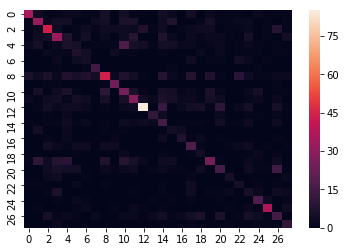

In [243]:
sns.heatmap(df)

Our heat map across the diagonal is showing the frequency of our accurate predictions. 

### Baseline Model: Logisitc Regression

In [39]:
lr= LogisticRegression()

In [40]:
X_train_lr=X_train.reshape(3831,2000)

In [41]:
X_test_lr=X_test.reshape(1212, 2000)

In [42]:
lr.fit(X_train_lr,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
lr.score(X_test_lr,y_test)

0.18460534898891062

In [43]:
y_predict_lr=lr.predict(X_test_lr)

In [44]:
y_predict_lr

array([20,  0,  0, ..., 17, 25, 27])

In [45]:
cm2=confusion_matrix(y_predict_lr,y_test)

In [46]:
df2=pd.DataFrame(cm2)

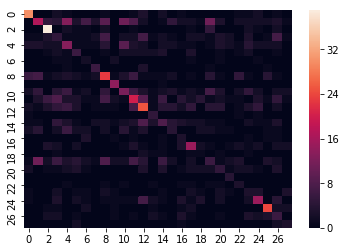

In [47]:
sns.heatmap(df2)

### Baseline model: Lasso

In [49]:
from sklearn.linear_model import Lasso

In [50]:
lasso= Lasso(alpha=.01)

In [51]:
X_train_lasso=X_train_lr
X_test_lasso=X_test_lr

In [52]:
lasso.fit(X_train_lasso,y_train)

C:\Users\Connor\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [53]:
lasso.score(X_test_lasso,y_test)

-0.5409860780692042

### Summary & Next Steps:

Keras Conv2d is the best model out of all, even though the accuracy score is 56%. This can be improved with more data points, more labelled audio files, as Keras (or any CNN, NN) requires large datasets for it to learn from. Training with more epochs is another way of improving accuracy, however probably can only be done in the cloud as 50 for conv2d is the maximum epochs that can be ran locally.

Also we could re-position this problem into 28 binary classification problems and converting each class into a binary label accordingly and fit a simple logistic regression model. Then combine the 28 sub-models in the end. 
Due to the imbalanced labels (after the binary conversion), we might need to oversample the minor class (1) with SMOTE, or undersample the major class (0) if more data can be obtained. 

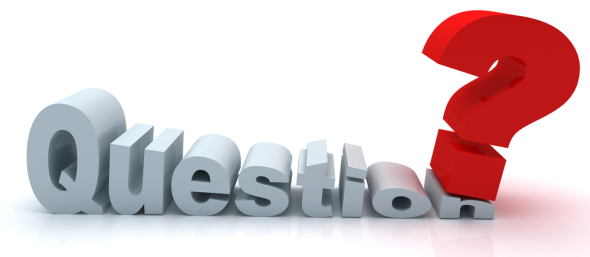

In [56]:
Image('Question.png')